# Image Colorization

In [1]:
from torch import *
import torchvision
from torchmetrics.functional import peak_signal_noise_ratio
from matplotlib import pyplot as plt
from copy import deepcopy
from tqdm import tqdm
from dataset import *
from model import *
import pickle 
from skimage.metrics import structural_similarity as ssim

## Read and build dataset

In [2]:
size = 256
mirflickr = Mirflickr('mirflickr25k')
train_dataloader, eval_dataloader = mirflickr.build_dataset(size=size, batch_size=16)

## Build Model

In [3]:
model = MainModel(size=size, pretrained=False)

### Define accuracy metrics

In [4]:
def compute_ssim(true, result, is_train=False):
    if is_train:
        true = true.detach().cpu().numpy()
        result = result.detach().cpu().numpy()
        
        a = ssim(true[:, 0, :, :], result[:, 0, :, :], data_range=true.max() - true.min())
        b = ssim(true[:, 1, :, :], result[:, 1, :, :], data_range=true.max() - true.min())
    else:
        true = true.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
        result = result.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
        
        a = ssim(true[:, :, 0], result[:, :, 0], data_range=true.max() - true.min())
        b = ssim(true[:, :, 1], result[:, :, 1], data_range=true.max() - true.min())
        
    return (a + b) / 2

## Load model and visualize the result
## Also with SSIM, PSNR, and L1 loss evaluation

In [5]:
model_result = torch.load("saved_weights/unet_GAN_25k")

In [6]:
def denormalize(img_norm):
    img_norm[:, :, 0] = (img_norm[:, :, 0] + 1.) * 50.
    img_norm[:, :, 1] = ifunc(img_norm[:, :, 1])
    img_norm[:, :, 2] = ifunc(img_norm[:, :, 2])
    return img_norm

PSNR score: 16.3629
SSIM score: -0.0022
Evaluation L1 loss: 0.1841


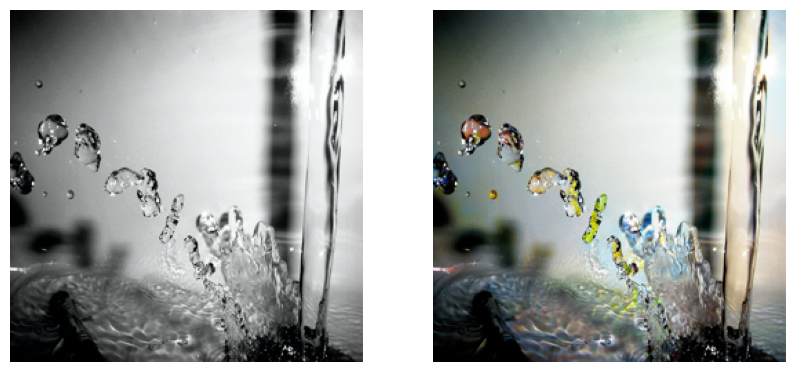

In [7]:
for data in eval_dataloader:
    L = data['L'].to(model.device)
    ab = data['ab'].to(model.device)
    
    if len(L) != 1 and len(ab) != 1:
        L = L[0, :, :, :].unsqueeze(0)
        ab = ab[0, :, :, :].unsqueeze(0)
    break
    
ab_zero = torch.tensor(0).expand_as(ab).float().to(model.device)
raw_input_image = torch.cat([L, ab_zero], dim=1)

input_image = raw_input_image.squeeze(0).permute(1, 2, 0)
input_image = input_image.detach().cpu().numpy()
input_ = lab2rgb(denormalize(input_image)) 

raw_true_image = torch.cat([L, ab], dim=1)
true_image = raw_true_image.squeeze(0).permute(1, 2, 0)
true_image = true_image.detach().cpu().numpy()
true = lab2rgb(denormalize(true_image)) 

colorized_result = model_result(L)
raw_colorized_image = torch.cat([L, colorized_result], dim=1)
colorized_image = raw_colorized_image.squeeze(0).permute(1, 2, 0)
colorized_image = colorized_image.detach().cpu().numpy()
result = lab2rgb(denormalize(colorized_image)) 

f, axarr = plt.subplots(1, 2, figsize=(10, 10))
axarr[0].imshow(input_)
axarr[1].imshow(result)
axarr[0].axis('off') 
axarr[1].axis('off') 

plt.savefig('result.png', transparent=True, bbox_inches='tight')

# Use PSNR metrics to evaluate the performance
# The range of PSNR score is [-inf, +inf]
# +inf means that they are identical
# -inf means that they are completely different (100% black and white image versus true colors)
print('PSNR score: %.4f' % (peak_signal_noise_ratio(ab, colorized_result)))

# SSIM compares the perceived quality between 2 images
# The range of SSIM is [-1, 1]
# Lower means very poor result
# Higher means excellent result
# -1: Anti-correlated
# 0: No similarity
# 1: Identical
print('SSIM score: %.4f' % (compute_ssim(ab, colorized_result)))

# Print the evaluation l1 loss
print('Evaluation L1 loss: %.4f' % (model.GLoss(ab, colorized_result)))

## Perform evaluation

In [ ]:
PSNR = []
SSIM = []
L1_Loss = []

for data in eval_dataloader:
    L = data['L'].to(model.device)
    ab = data['ab'].to(model.device)
    
    ab_zero = torch.tensor(0).expand_as(ab).float().to(model.device)
    raw_input_image = torch.cat([L, ab_zero], dim=1)
    input_image = raw_input_image.squeeze(0).permute(1, 2, 0)
    input_image = input_image.detach().cpu().numpy()
    input_ = lab2rgb(denormalize(input_image)) 

    raw_true_image = torch.cat([L, ab], dim=1)
    true_image = raw_true_image.squeeze(0).permute(1, 2, 0)
    true_image = true_image.detach().cpu().numpy()
    true = lab2rgb(denormalize(true_image)) 

    colorized_result = model_result(L)
    raw_colorized_image = torch.cat([L, colorized_result], dim=1)
    colorized_image = raw_colorized_image.squeeze(0).permute(1, 2, 0)
    colorized_image = colorized_image.detach().cpu().numpy()
    result = lab2rgb(denormalize(colorized_image)) 
    

    PSNR.append(float(peak_signal_noise_ratio(ab, colorized_result)))
    SSIM.append(float(compute_ssim(ab, colorized_result)))
    L1_Loss.append(float(model.GLoss(ab, colorized_result)))

In [ ]:
def avg(l):
    total = 0
    for i in l:
        total += i
    return total / len(l)

print("Evaluation performance:")
avg(PSNR), avg(SSIM), avg(L1_Loss)